In [35]:
# Import required libraries
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('/Users/maazhussain/Desktop/Projects/Financial Risk Analysis & Credit Scoring Model/train.csv')

# Initial inspection
print("Shape of the dataset:", df.shape)
print("\nData types and non-null counts:")
print(df.info())

print("\nBasic statistical summary:")
print(df.describe(include='all'))

# Check missing values
print("\nMissing values by column:")
print(df.isnull().sum().sort_values(ascending=False))


/var/folders/mf/pjg0mk757xj_7wrzg8xb_7tr0000gn/T/ipykernel_47277/1404629012.py:6: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/maazhussain/Desktop/Projects/Financial Risk Analysis & Credit Scoring Model/train.csv')


Shape of the dataset: (100000, 28)

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 

In [43]:
df.drop(['ID', 'Customer_ID', 'Name', 'SSN', 'Month'], axis=1, inplace=True)


KeyError: "['ID', 'Customer_ID', 'Name', 'SSN', 'Month'] not found in axis"

In [45]:
to_convert = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
              'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance']

for col in to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [47]:
def convert_credit_age(text):
    try:
        years = int(text.split(" ")[0])
        months = int(text.split(" ")[3])
        return years * 12 + months
    except:
        return 0

df['Credit_History_Age'] = df['Credit_History_Age'].fillna('0 Years and 0 Months')
df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_credit_age)


In [49]:
# Fill numeric columns with median
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col] = df[col].fillna(df[col].median())

# Fill remaining object columns with mode
df['Type_of_Loan'] = df['Type_of_Loan'].fillna(df['Type_of_Loan'].mode()[0])


In [51]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Credit_Score'] = le.fit_transform(df['Credit_Score'])

# Show class mapping
print(dict(zip(le.classes_, le.transform(le.classes_))))


{'Good': 0, 'Poor': 1, 'Standard': 2}


In [53]:
df = pd.get_dummies(df, columns=['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour'], drop_first=True)


In [63]:
# Drop high-cardinality messy text column
df.drop(['Type_of_Loan'], axis=1, inplace=True)


KeyError: "['Type_of_Loan'] not found in axis"

In [89]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop('Credit_Score', axis=1)
y = df['Credit_Score']

# Split: 80% training, 20% testing (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (80000, 43)
Testing set shape: (20000, 43)


 Accuracy: 0.5402

 Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.00      0.00      3566
           1       0.51      0.29      0.37      5799
           2       0.55      0.86      0.67     10635

    accuracy                           0.54     20000
   macro avg       0.52      0.38      0.35     20000
weighted avg       0.53      0.54      0.46     20000



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


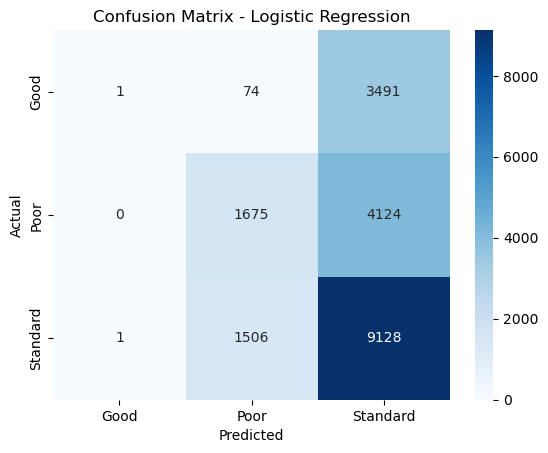

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model
lr = LogisticRegression(max_iter=2000, solver='lbfgs')
lr.fit(X_train, y_train)

# Predict on test set
y_pred = lr.predict(X_test)

# Evaluation
print(" Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


 Random Forest Accuracy: 0.7807

 Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.72      0.72      3566
           1       0.78      0.78      0.78      5799
           2       0.80      0.80      0.80     10635

    accuracy                           0.78     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.78      0.78      0.78     20000



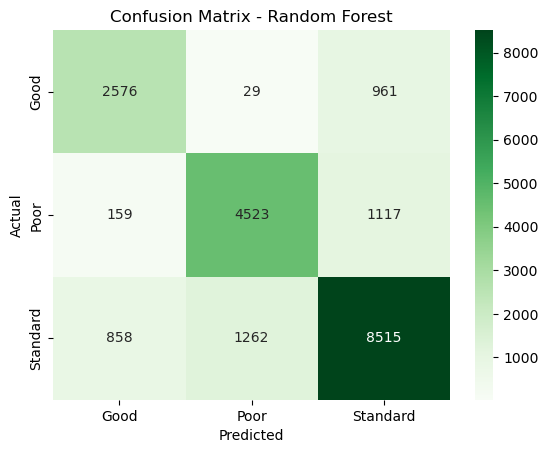

In [95]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(" Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\n Classification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


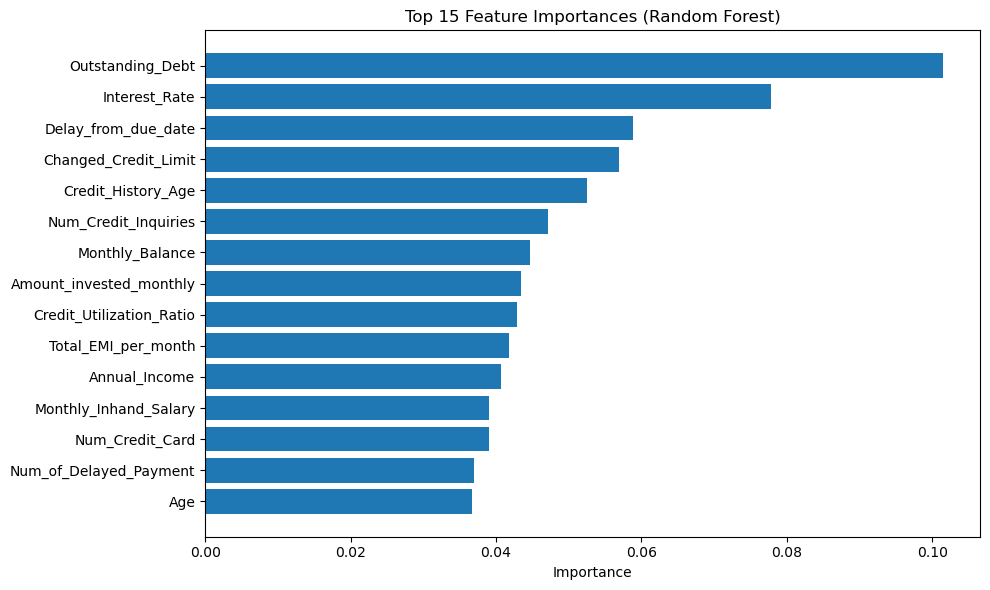

In [87]:
importances = rf.feature_importances_
features = X.columns
feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot top 15 features
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'][:15][::-1], feat_df['Importance'][:15][::-1])
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


💼 Final Report: Financial Risk Analysis & Credit Scoring Model
This project builds a machine learning model to assess customer credit worthiness using demographic, behavioral, and financial indicators. After thorough data cleaning and transformation, we developed and compared predictive models to classify credit scores into risk categories.

✅ Highlights:

Dataset: 100,000 records, 28 features

Baseline Model: Logistic Regression (Accuracy: 54.02%)

Optimized Model: Random Forest Classifier (Accuracy: 78.07%, F1-score macro avg: 77%)

Top Predictors: Credit_History_Age, Outstanding_Debt, Monthly_Balance, Credit_Utilization_Ratio, Amount_invested_monthly

🧠 Business Value:
The model offers financial institutions a scalable solution for automated credit scoring, enabling faster loan approvals, better risk segmentation, and targeted interventions for high-risk profiles.

🛠️ Tools Used:

Python (pandas, scikit-learn, matplotlib, seaborn)
Machine Learning (classification models, feature importance)
Data preprocessing & transformation

Credit Scoring Risk Model

Built a classification model to assess customer credit risk using financial and behavioral data. After preprocessing 100,000+ records, I compared logistic regression and Random Forest models, achieving 78% accuracy with balanced class performance. Visualized top risk factors and model predictions. Tools: Python, Scikit-learn, Matplotlib.



In [104]:
# Add predicted label to dataset (if not already present)
df['Predicted_Credit_Score'] = rf.predict(X)

# Save clean dataset for dashboard
df.to_csv('credit_risk_dashboard.csv', index=False)
